In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from itertools import chain

Читаем табличку с адресами и координатами:

In [2]:
coords_db = pd.read_csv("moscow_coords.csv", usecols=["ADDRESS", "geoData"], dtype=str)

In [3]:
print(coords_db.shape)
coords_db.head()

(406934, 2)


,ADDRESS,geoData
0,"город Москва, Варшавское шоссе, дом 150, строе...","{ ""coordinates"" : [ [ [ 37.6013796035561 , 55...."
1,"город Москва, Косинская улица, дом 26А","{ ""coordinates"" : [ [ [ 37.8279504545784 , 55...."
2,"город Москва, Гороховский переулок, дом 21","{ ""coordinates"" : [ [ [ 37.6682995208392 , 55...."
3,"город Москва, Тагильская улица, дом 4, строени...","{ ""coordinates"" : [ [ [ 37.7527975561661 , 55...."
4,"город Москва, Ленинградский проспект, дом 73А,...","{ ""coordinates"" : [ [ [ 37.5136462392231 , 55...."


Парсим координаты:

In [4]:
def parse_coordinate(str_dct):
    if not isinstance(str_dct, str) or str_dct == "Значение превышает максимальный размер ячейки Excel.":
        return np.zeros(2)
    
    d = json.loads(str(str_dct))
    c = d["coordinates"]
    c = list(chain.from_iterable(c))
    if isinstance(c, list) and len(c) > 1:
        e = np.concatenate([np.array(r).reshape((-1, 2)) for r in c])
    else:
        e = np.array(c)
    return np.array(e).mean(axis=0)


coords_db["coor_x"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[0])
coords_db["coor_y"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[1])
coords_db = coords_db.drop(columns=["geoData"])

In [5]:
coords_db = coords_db.rename(columns={"ADDRESS": "address"})
print(coords_db.shape)
coords_db.head()

(406934, 3)


,address,coor_x,coor_y
0,"город Москва, Варшавское шоссе, дом 150, строе...",37.601252,55.599249
1,"город Москва, Косинская улица, дом 26А",37.828115,55.717493
2,"город Москва, Гороховский переулок, дом 21",37.668093,55.766224
3,"город Москва, Тагильская улица, дом 4, строени...",37.752887,55.818257
4,"город Москва, Ленинградский проспект, дом 73А,...",37.513546,55.803510


Уберём все строчки, в которых слово город встречается дважды или есть слово послеление, чтобы обрабатывать меньше строк - такие адреса точно не внутри садового.

In [6]:
def adr_is_bad(s):
    x = s.lower()
    cities_count = len(re.findall("город ", x))
    settl_count = len(re.findall("поселение ", x))
    settl_2_count = len(re.findall("поселок ", x))
    return cities_count > 1 or settl_count + settl_2_count != 0

In [7]:
coords_db = coords_db[~coords_db["address"].apply(adr_is_bad)]

In [8]:
print(coords_db.shape)
coords_db.sample(5)

(155526, 3)


,address,coor_x,coor_y
123850,"город Москва, Буракова улица, дом 27, корпус 24",37.738059,55.757528
25659,"город Москва, улица Лобачевского, владение 92А...",37.484564,55.677538
240619,"город Москва, Таманская улица, дом 3, строение 18",37.442838,55.778064
38236,"город Москва, улица Багрицкого, дом 10, корпус 2",37.434702,55.723042
25613,"город Москва, Большая Садовая улица, дом 16",37.597416,55.768341


## Переходим к полигону:

In [9]:
poly_points = []
with open("polygon_2.txt", "r") as f:
    for line in f.readlines():
        poly_points.append(line.strip().split(","))
poly_points = np.array(poly_points, dtype=float)[:, :-1]

In [10]:
house_coords = coords_db[["coor_x", "coor_y"]][coords_db[["coor_x", "coor_y"]]!=0].dropna().values

Уберём дома, которые точно вне полигона:

In [11]:
def get_subhouses(houses, poly):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    
    a = houses[:, 0] > x_min
    b = np.logical_and(a, houses[:, 0] < x_max)
    c = np.logical_and(b, houses[:, 1] > y_min)
    d = np.logical_and(c, houses[:, 1] < y_max)

    return d

houses_mask = get_subhouses(coords_db[["coor_x", "coor_y"]].values, poly_points)

In [12]:
houses_mask.shape[0], houses_mask.sum()

(155526, 12059)

Осталось 12к домов

In [13]:
coords_sub_db = coords_db[houses_mask]
house_coords = coords_sub_db[["coor_x", "coor_y"]].values

In [14]:
import math
from PIL import Image

In [15]:
img = plt.imread('im0.jpeg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

На глаз разделим внешние и внутренние точки полигона:

In [16]:
n = poly_points.shape[0] // 2 + 6 

poly_1 = poly_points[:n, :]
poly_2 = poly_points[n:, :]

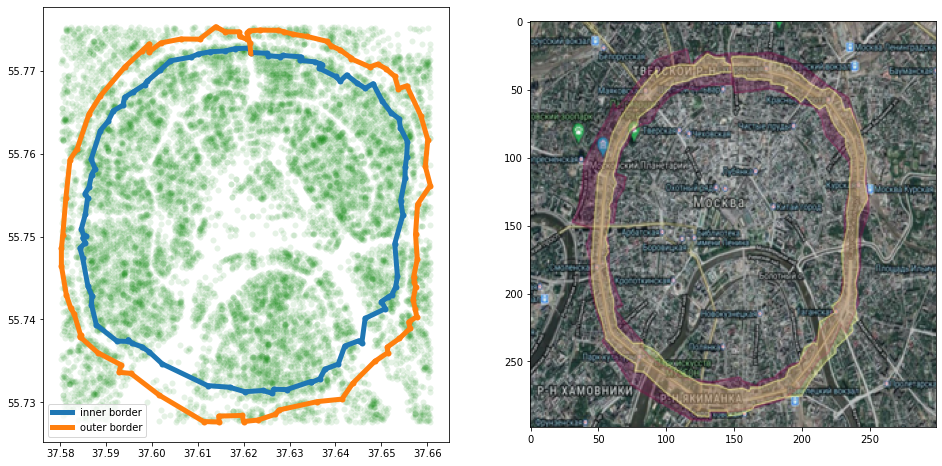

In [17]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].scatter(house_coords[:, 0], house_coords[:, 1], linewidths=0.001, alpha=0.1, c="g")
axes[0].scatter(poly_1[:, 0], poly_1[:, 1], linewidths=0.005)
axes[0].scatter(poly_2[:, 0], poly_2[:, 1], linewidths=0.005)

axes[0].plot(poly_1[:, 0], poly_1[:, 1], linewidth=5, label="inner border")
axes[0].plot(poly_2[:, 0], poly_2[:, 1], linewidth=5, label="outer border")
axes[0].legend()

#axes[0].set_ylim(55.72, 55.78)
#axes[0].set_xlim(37.57, 37.67)

axes[1].imshow(img)

plt.show()

Научимся различать точки внутри полигона (между синей и оранжевой линиями) от всех остальных:

In [18]:
def area(x1, y1, x2, y2, x3, y3): 
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                + x3 * (y1 - y2)) / 2.0) 

def isInside(x1, y1, x2, y2, x3, y3, x, y): 
    ABC = area (x1, y1, x2, y2, x3, y3) 
    PBC = area (x, y, x2, y2, x3, y3)  
    PAC = area (x1, y1, x, y, x3, y3)
    PAB = area (x1, y1, x2, y2, x, y) 

    return np.isclose(ABC, PBC + PAC + PAB)

def point_inside_poly(poly, point):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    if point[0] < x_min or point[0] > x_max or point[1] < y_min or point[1] > y_max:
        return False
    
    center = poly.mean(axis=0)
    res = False
    for a, b in zip(poly, np.concatenate([poly[1:], poly[:1]])):
        res = res or isInside(*center, *a, *b, *point)
    return res

In [19]:
inside_poly1 = np.array([point_inside_poly(poly_1, h) for h in house_coords])
inside_poly2 = np.array([point_inside_poly(poly_2, h) for h in house_coords])
between_polys = np.logical_xor(inside_poly1, inside_poly2)
print(np.sum(between_polys))

1795


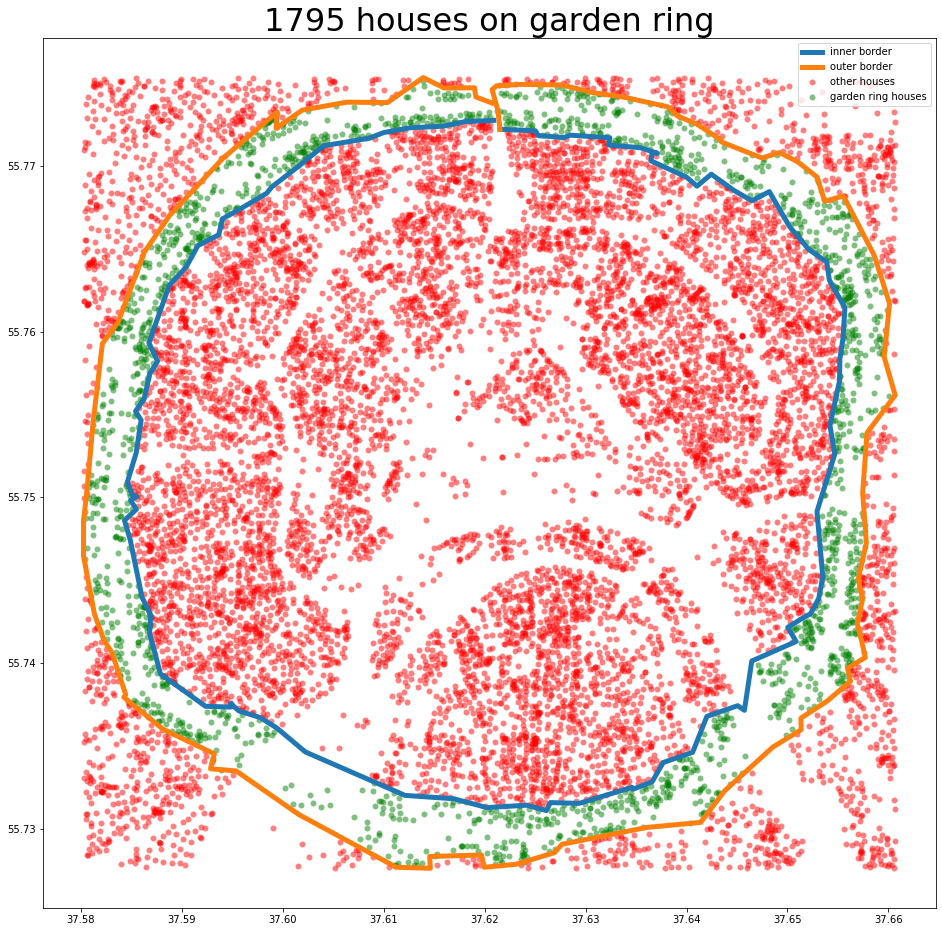

In [20]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 16), sharex=True, sharey=True)


axes.set_title("{} houses on garden ring".format(np.sum(between_polys)), size=32)

axes.scatter(house_coords[~inside_poly2, 0], house_coords[~inside_poly2, 1], linewidths=0.0001, alpha=0.5, c="r")
axes.scatter(house_coords[inside_poly1, 0], house_coords[inside_poly1, 1], linewidths=0.0001, alpha=0.5, c="r", label="other houses")
axes.scatter(house_coords[between_polys, 0], house_coords[between_polys, 1], linewidths=0.0001, alpha=0.5, c="g", label="garden ring houses")
axes.plot(poly_1[:, 0], poly_1[:, 1], linewidth=5, label="inner border")
axes.plot(poly_2[:, 0], poly_2[:, 1], linewidth=5, label="outer border")
plt.legend()

plt.show()

In [21]:
garden_ring_db = coords_sub_db[between_polys]

In [22]:
print(garden_ring_db.shape)
garden_ring_db.sample(10)

(1795, 3)


,address,coor_x,coor_y
172641,"город Москва, внутригородская территория муниц...",37.584871,55.760260
56604,"город Москва, Николоямская улица, дом 33, стро...",37.657725,55.747977
7535,"город Москва, Вспольный переулок, дом 21",37.588287,55.762523
28632,"город Москва, улица Земляной Вал, дом 52, стро...",37.654137,55.749013
98826,"город Москва, Большая Никитская улица, дом 56,...",37.587114,55.758804
128141,"город Москва, Садовническая улица, дом 79",37.643389,55.734948
171985,"город Москва, Гончарная набережная, дом 9/16, ...",37.648629,55.737452
42848,"город Москва, Трубная улица, дом 37/6",37.624504,55.773196
36747,"город Москва, Старая Басманная улица, дом 9, с...",37.656642,55.765614
24924,"город Москва, Садовая-Кудринская улица, дом 8",37.586211,55.760437


# Займёмся адресами:

Конвертируем всякие сокращения (используем те же сокращения, что и в таблице с портала mos.ru, импортируем её позже)

In [23]:
shortenings = [
    ("город", "г"),
    ("проспект", "пркт"),
    ("улица", "ул"),
    ("бульвар", "бр"),
    ("переулок", "пер"),
    ("проезд", "проезд"),
    ("шоссе", "ш"),
    ("площадь", "пл"),
    ("набережная", "наб"),
    ("дом", "д"),
    ("корпус", "к"),
    ("строение", "стр"),
    ("сооружение", "сооруж"),
    ("большой", "б"),
    ("большая", "б"),
    ("средний", "ср"),
    ("средняя", "ср"),
    ("малый", "м"),
    ("малая", "м")
]

In [24]:
def shorten_address(s, shrt=shortenings):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    
    for a, b in shortenings:
        x = re.sub(a, b, x)
    x = re.sub(r"г москва", "", x)
    return x.strip()

def clip_bad_prefix(s, prefix="внутригская территория муниципальный округ"):
    if prefix in s:
        return " ".join(s.split()[len(prefix.split()) + 1:])

    return s

s = "внутригская территория муниципальный округ замоскворечье 6й монетчиковский пер д 12"
print(clip_bad_prefix(s))

6й монетчиковский пер д 12


In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
garden_ring_db["short_address"] = garden_ring_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [27]:
garden_ring_db.sample(10)

,address,coor_x,coor_y,short_address
63394,"город Москва, Оружейный переулок, дом 15А",37.600629,55.772163,оружейный пер д 15а
165321,"город Москва, Житная улица, дом 12, строение 3",37.616798,55.731419,житная ул д 12 стр 3
27937,"город Москва, Зубовский бульвар, дом 2, строен...",37.593190,55.737019,зубовский бр д 2 стр 3
66243,"город Москва, Николоямская улица, дом 31, стро...",37.657255,55.747869,николоямская ул д 31 стр 2
121017,"город Москва, Смоленская площадь, дом 6, строе...",37.583858,55.749227,смоленская пл д 6 стр 3
172503,"город Москва, Турчанинов переулок, дом 3, стро...",37.597514,55.735624,турчанинов пер д 3 стр 5б/н
106550,"город Москва, улица Тимура Фрунзе, дом 30, стр...",37.586962,55.737050,ул тимура фрунзе д 30 стр 1
106159,"город Москва, Новинский бульвар, дом 3, строен...",37.580963,55.751337,новинский бр д 3 стр 2
123928,"город Москва, Зубовская площадь, дом 3, строен...",37.585463,55.737648,зубовская пл д 3 стр 3
77754,"город Москва, переулок Обуха, дом 7, строение 1",37.655027,55.752793,пер обуха д 7 стр 1


Напишем небольшой парсер адресов:

In [28]:
s = "ул пречистенка д 40/2 стр 1"
def parse_address(s, prefixes=["д", "к", "стр", "сооруж"]):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    x = re.sub(r"г москва", "", x)

    entities = {}
    for prefix in prefixes:
        pattern = re.compile(prefix + " " + "(\d*\w*/?\d*\w*)")
        finds = re.findall(pattern, x)
        if len(finds):
            entity = re.findall(pattern, x)[0]
            entities[prefix] = entity
            x = re.sub(prefix + " " + entity, "", x)
        x = re.sub(r"\W+", " ", x)

    return x.strip(), entities

def match_address(s, addresses):
    pattern = "(" + "|".join(addresses) + ")"
    return ",".join(re.findall(pattern, s))


def norm_address(x):
    return " ".join(sorted(x.split()))

print(parse_address(s))
print(norm_address(s))

('ул пречистенка', {'д': '40/2', 'стр': '1'})
1 40/2 д пречистенка стр ул


## Вычитываем табличку с описанием домов

In [29]:
house_descr_db = pd.read_csv("data/dump2.csv")

In [30]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 60)


,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,...,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
0,8649748,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,"0,00",Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки
1,9370109,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
2,8963246,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,7.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,NaN,Отсутствует,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки
3,8932138,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
4,8932139,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено


Оставляем только интересные нам столбцы. Можно посмотреть, сколько в них пропусков (в каждом столбце):

In [31]:
useful_columns = [
    "address",
    "house_number",
    "building",
    "block",
    "letter",
    "floor_count_max",
    "floor_count_min",
    "entrance_count",
    "quarters_count",
    "living_quarters_count",
    "unliving_quarters_count" 
]

In [32]:
house_descr_db = house_descr_db[useful_columns]

In [33]:
house_descr_db.isnull().sum(axis = 0)

address                        0
house_number                 470
building                   32706
block                      18326
letter                     34417
floor_count_max              304
floor_count_min             1589
entrance_count               339
quarters_count                 0
living_quarters_count       1552
unliving_quarters_count     1942
dtype: int64

Проделываем ту же процедуру сокращения адресов:

In [34]:
house_descr_db["short_address"] = house_descr_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [35]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 12)


,address,house_number,building,block,letter,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,short_address
0,"г. Москва, д. 9, к. 1",9,NaN,1,NaN,9.0,9.0,4.0,144,144.0,0.0,д 9 к 1
1,"г. Москва, д. 14, к. 1",14,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,д 14 к 1
2,"г. Москва, д. 42, к. 2",42,NaN,2,NaN,17.0,17.0,7.0,476,474.0,2.0,д 42 к 2
3,"г. Москва, д. 2301",2301,NaN,NaN,NaN,13.0,NaN,6.0,0,NaN,NaN,д 2301
4,"г. Москва, д. 2302",2302,NaN,NaN,NaN,11.0,9.0,3.0,0,NaN,NaN,д 2302


Создадим сущность `norm_address`, в котором слова из `short address` расположены в алфавитном порядке:

In [36]:
garden_ring_db["norm_address"] = garden_ring_db.short_address.apply(norm_address)
house_descr_db["norm_address"] = house_descr_db.short_address.apply(norm_address)

In [37]:
shorts_garden = set(garden_ring_db["short_address"].values)
norms_garden = set(garden_ring_db["norm_address"].values)

shorts_descr = set(house_descr_db["short_address"].values) 
norms_descr = set(house_descr_db["norm_address"].values) 

Посмотрим, сколько адресов из таблицы с координатами нашлось:

In [38]:
shorts_intersect =  [x for x in shorts_garden if x in shorts_descr]
norms_intersect = [x for x in norms_garden if x in norms_descr]
len(shorts_intersect), len(norms_intersect)

(64, 306)

Нашлось 306 домов. Посмотрим, какие не нашлись.

In [39]:
def address_lookup(series, s):
    return series[series.str.contains(s)]

In [40]:
lost_norms_addresses = [x for x in norms_garden if x not in norms_descr]

Посмотрим, какие там самые частые слова

In [41]:
from collections import Counter
from nltk.tokenize import WhitespaceTokenizer

In [42]:
c = Counter()
c_alpha = Counter()
tokenizer = WhitespaceTokenizer()

for adr in lost_norms_addresses:
    c_alpha.update(tokenizer.tokenize("".join([z for z in adr if z.isalpha() or z == " "])))
    c.update(tokenizer.tokenize(adr))

In [43]:
c_alpha.most_common()

[('д', 1367),
 ('стр', 1123),
 ('ул', 902),
 ('пер', 245),
 ('вал', 160),
 ('б', 155),
 ('бр', 127),
 ('а', 119),
 ('земляной', 107),
 ('владение', 104),
 ('пл', 79),
 ('садоваякудринская', 59),
 ('й', 50),
 ('наб', 46),
 ('м', 46),
 ('сооруж', 45),
 ('зубовский', 42),
 ('смоленский', 41),
 ('тупик', 40),
 ('садовая', 39),
 ('новинский', 35),
 ('садоваясамотёчная', 34),
 ('садоваяспасская', 34),
 ('садоваячерногрязская', 31),
 ('к', 30),
 ('крымский', 27),
 ('воронцовская', 27),
 ('садовническая', 25),
 ('пркт', 24),
 ('сухаревская', 24),
 ('казённый', 23),
 ('коровий', 23),
 ('гончарная', 22),
 ('хомутовский', 22),
 ('николоямская', 21),
 ('радищевская', 20),
 ('оружейный', 19),
 ('бахрушина', 19),
 ('бн', 18),
 ('садоваятриумфальная', 18),
 ('валовая', 17),
 ('александра', 17),
 ('солженицына', 17),
 ('басманная', 16),
 ('садоваясухаревская', 16),
 ('нижняя', 15),
 ('садоваякаретная', 15),
 ('проезд', 15),
 ('цветной', 15),
 ('поварская', 14),
 ('гончарный', 14),
 ('смоленскаясенная'

Пойдём разбираться, что там с названиями улиц:

In [44]:
for z in address_lookup(pd.Series(lost_norms_addresses), "земляной"):
    print(z)

25 5 вал д земляной стр ул
12/7 5 вал д земляной стр ул
10 32 вал д земляной стр ул
13 29 вал д земляной стр ул
1 7 вал д земляной стр ул
14/16 2 вал д земляной стр ул
30 7 вал д земляной стр ул
58 вал д земляной ул
62 вал д земляной ул
14 29 вал д земляной стр ул
72а вал д земляной ул
1 76/21 вал д земляной стр ул
2 25 вал д земляной стр ул
24/32 7 вал владение земляной стр ул
3 68/18 вал д земляной стр ул
11 29 вал д земляной стр ул
4 56 вал д земляной стр ул
29 3 вал д земляной стр ул
12/7 4 вал д земляной стр ул
3 56 вал д земляной стр ул
71 вал д земляной ул
73 вал д земляной ул
2 24 вал д земляной сооруж ул
2 41/2 вал д земляной стр ул
9 вал д земляной ул
5 52 вал д земляной стр ул
1 44а вал д земляной стр ул
48а 8 вал д земляной стр ул
1 34а вал д земляной стр ул
3 30 вал д земляной стр ул
7 вал д земляной ул
1822 5 вал д земляной стр ул
2 50а вал д земляной стр ул
2 26 вал д земляной стр ул
3 73 вал д земляной стр ул
77 вал д земляной ул
1416 5 вал д земляной стр ул
1 68 вал д 

In [45]:
address_lookup(house_descr_db["short_address"], "земляной")

10109        ул земляной вал д 1/4 стр 1
10110        ул земляной вал д 1/4 стр 2
10111                ул земляной вал д 2
10112        ул земляной вал д 3/1 стр 6
10113        ул земляной вал д 3/1 стр 7
10114          ул земляной вал д 6 стр 1
10115          ул земляной вал д 6 стр 2
10116               ул земляной вал д 10
10117       ул земляной вал д 12/7 стр 1
10118       ул земляной вал д 1416 стр 1
10119       ул земляной вал д 1822 стр 1
10120       ул земляной вал д 1822 стр 2
10121       ул земляной вал д 21/2 стр 1
10122      ул земляной вал д 21/24 стр 2
10123      ул земляной вал д 21/24 стр 3
10124         ул земляной вал д 23 стр 1
10125      ул земляной вал д 24/30 стр 1
10126     ул земляной вал д 24/30 стр 1а
10127            ул земляной вал д 24/32
10128               ул земляной вал д 25
10129         ул земляной вал д 27 стр 1
10130         ул земляной вал д 27 стр 2
10131               ул земляной вал д 32
10132        ул земляной вал д 34 стр 3а
10133         ул

In [46]:
address_lookup(garden_ring_db["short_address"], "земляной")

412                ул земляной вал д 32
1356      ул земляной вал д 52/16 стр 1
1619               ул земляной вал д 58
1626         ул земляной вал д 64 стр 2
2094         ул земляной вал д 30 стр 7
                      ...              
341123             ул земляной вал д 70
365505    ул земляной вал д 14/16 стр 2
397050       ул земляной вал д 24 стр 3
397767     ул земляной вал д 41/2 стр 2
401921    ул земляной вал д 76/21 стр 2
Name: short_address, Length: 145, dtype: object

Выглядит так, что правда многих домов нет в базе с мос.ру.

Соберём статистику по тем, что есть:

In [47]:
garden_house_desr = house_descr_db[house_descr_db["norm_address"].isin(norms_garden)]

In [49]:
for_stats = garden_house_desr
for_stats.loc[:, "groupby"] = "total"
for_stats.groupby("groupby").agg(
    {
         "address": ["count"],
         "living_quarters_count":["mean",  "sum"],
         "quarters_count" : ["sum"],
         "entrance_count": ["mean",  "sum"],
         "floor_count_min": ["min", "mean", "max"],
         "floor_count_max": ["min", "mean", "max"],
    })

address living_quarters_count          quarters_count entrance_count  \
          count                  mean      sum            sum           mean   
groupby                                                                        
total       306             55.833333  16415.0          18290           2.92   

               floor_count_min                floor_count_max              
           sum             min     mean   max             min  mean   max  
groupby                                                                    
total    876.0             0.0  5.22449  17.0             2.0  6.84  26.0